In [138]:
import ee
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geetools
import eemont
import geemap
from ee_extra.TimeSeries.core import getTimeSeriesByRegion

from masks import mask_MODIS_clouds, MODIS_Mask_QC, mask_s2_clouds, mask_s2_clouds_collection, csPlus_mask_collection
import masks

# Path to the private key file
key_path = 'Access/ee-martinparker637-e68fde65abb4.json'

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=['https://www.googleapis.com/auth/earthengine'])

# Initialize Earth Engine with the service account credentials
ee.Initialize(credentials)

In [140]:
def mask_other(img):
    return img.updateMask(img.neq(0))


In [141]:
root_directory = ''

In [143]:
def rvi_from_s1_grd(image):
    sigma = ee.Image(10).pow(image.divide(10)) # Convert dB values to linear scale
    ## Compute RVI using the formula: RVI = (4 * VH) / (VH + VV)
    rvi = sigma.expression('(4 * vh) / (vh + vv)', {
        'vv': sigma.select('VV'),
        'vh': sigma.select('VH')
    }).rename('RVI');

  # Apply a 30-meter focal median filter for noise reduction
    rviSmoothed = rvi#.focalMedian(30, 'square', 'meters');

  #Copy time properties and return the processed image
    return rviSmoothed.copyProperties(image, ['system:time_start', 'system:time_end'])


In [144]:
def map_SAR_bands(instrument = 'COPERNICUS/S1_GRD',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=1500, bands = ['EVI','NDVI', 'SAVI', 'NDWI', 'CIG'], img_index = 0):
    coord = coords[0]
    IC_SAR, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale=mask_scale, buffer_size=buffer_size,
                                           indices = False)
    location = box_around_point(coord, 0.01)
    
    fig, axs = plt.subplots(1, 4, figsize = (10, 5))
    for band_index, band in enumerate(['VH', 'VV']):
        img2ndImage=get_image_index(IC_SAR, img_index)
        img2ndImage.geetools.plot(bands = [band], ax = axs[band_index], region=location,cmap="viridis")
    #fig.savefig('manyplots.jpg')
    RVI = IC_SAR.map(rvi_from_s1_grd)
    img2ndImage=get_image_index(RVI, img_index)
    img2ndImage.geetools.plot(bands = ['RVI'], ax = axs[2], region=location,cmap="viridis")

    IC_VIS, vectors = initialise_comparison(instrument = 'COPERNICUS/S2_SR_HARMONIZED', coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale=mask_scale, buffer_size=buffer_size,
                                           indices = True)
    
    masked = csPlus_mask_collection(IC_VIS)
    img2ndImage=get_image_index(IC_VIS, (2*img_index) + 1)
    img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs[3], region=location,cmap="viridis")
    

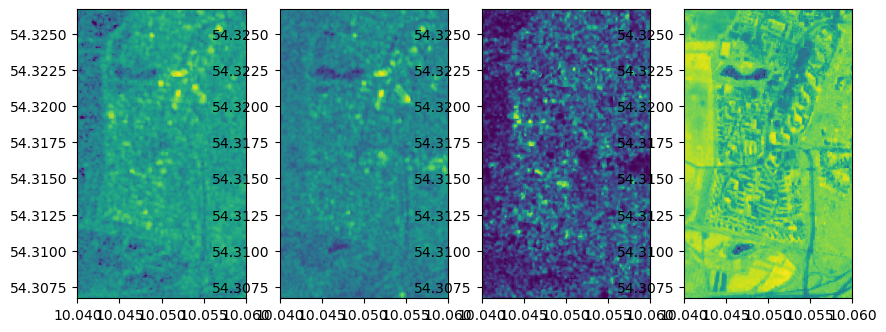

In [113]:
map_SAR_bands()

In [248]:
def plot_SAR_bands(instrument = 'COPERNICUS/S1_GRD',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'mean',
                      mask_scale=10, buffer_size=1500, SAR_bands = ['VV', 'VH'], img_index = 0):
    fig, axs = plt.subplots(len(coords), 1, figsize = (10, 15))
    colour_list = ['blue', 'red', 'green', 'black', 'purple']
    linestyle_list = ['solid', 'solid', 'dotted', 'dashed', 'dashdot']
    for coord_index, coord in enumerate(coords):
        print(f'{coord_index + 1}th coord')
        print('First download raw VV and VH')
        IC_SAR, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                country = country, crop_type = crop_type, 
                                                year = year, root_directory = root_directory,
                                                mask_scale=mask_scale, buffer_size=buffer_size,
                                                indices = False)
        location = box_around_point(coord, 0.01)
        
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
        ts = getTimeSeriesByRegion(IC_SAR, 
                                   reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                   geometry = random_points, 
                                   bands = SAR_bands, scale = mask_scale)
        try:
            x = geemap.ee_to_df(ts)
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x = x.where(x['VV']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xreduced['CR'] = xreduced['VH']/xreduced['VV']
        except:
            continue
        for band_index, SAR_band in enumerate(SAR_bands + ['CR']):
            colour = ['blue', 'red', 'green', 'black', 'purple'][band_index]
            line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][band_index]
            print(xreduced[SAR_band].max(), np.sign(xreduced[SAR_band].max()))
            axs[coord_index].plot(xreduced['date'], (xreduced[SAR_band]/np.max([1, np.abs(xreduced[SAR_band]).max()]))*np.sign(xreduced[SAR_band].mean()), c = colour, label = SAR_band)
        
        print('Now convert to RVI')
        RVI = IC_SAR.map(rvi_from_s1_grd)
        ts = getTimeSeriesByRegion(RVI, 
                                   reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                   geometry = random_points, 
                                   bands = ['RVI'], scale = mask_scale)
        
        x = geemap.ee_to_df(ts).sort_index(ascending=True)
        x['date'] = pd.to_datetime(x['date'])
        x = x.sort_values(by='date')
        x = x.where(x['RVI']!=-9999).dropna()
        x = x.where(x['RVI'] < 2).dropna()
        xreduced = x.where(x['reducer'] == reducer_code).dropna()
        colour = ['blue', 'red', 'green', 'black', 'purple'][band_index + 1]
        line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][band_index + 1]
        axs[coord_index].plot(xreduced['date'], (xreduced['RVI']/np.max([1, np.abs(xreduced['RVI']).max()]))*np.sign(xreduced['RVI'].max()), c = colour, linestyle = line_style, label = 'RVI')
    
        print('Now compare to VIS')
        IC_VIS, vectors = initialise_comparison(instrument = 'COPERNICUS/S2_SR_HARMONIZED', coord = coord, 
                                                country = country, crop_type = crop_type, 
                                                year = year, root_directory = root_directory,
                                                mask_scale=mask_scale, buffer_size=buffer_size,
                                                indices = True)
        
        masked = csPlus_mask_collection(IC_VIS)
        ts = getTimeSeriesByRegion(masked, 
                                   reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()], 
                                   geometry = random_points, 
                                   bands = ['NDVI'], scale = mask_scale)
        x = geemap.ee_to_df(ts)
        x['date'] = pd.to_datetime(x['date'])
        x = x.sort_values(by='date')
        x = x.where(x['NDVI']!=-9999).dropna()
        xreduced = x.where(x['reducer'] == reducer_code).dropna()
        colour = colour_list[band_index + 2]
        line_style = linestyle_list[band_index + 2]
        axs[coord_index].plot(xreduced['date'], (xreduced['NDVI']), c = colour, label = 'NDVI', linestyle = line_style)
        axs[coord_index].set_title('SAR vs NDVI')
        axs[coord_index].tick_params(labelrotation=45)
        axs[coord_index].set_ylim([0, 1])    
    
    fig.legend()
    #

1th coord
First download raw VV and VH
-6.845707421817235 -1.0
-14.162066385673317 -1.0
2.4469305980038163 1.0
Now convert to RVI
Now compare to VIS
2th coord
First download raw VV and VH
-8.356253999288104 -1.0
-15.067237607507888 -1.0
2.4119863786941957 1.0
Now convert to RVI
Now compare to VIS
3th coord
First download raw VV and VH
-7.443338460696652 -1.0
-15.200980262337485 -1.0
2.4730917262841072 1.0
Now convert to RVI
Now compare to VIS


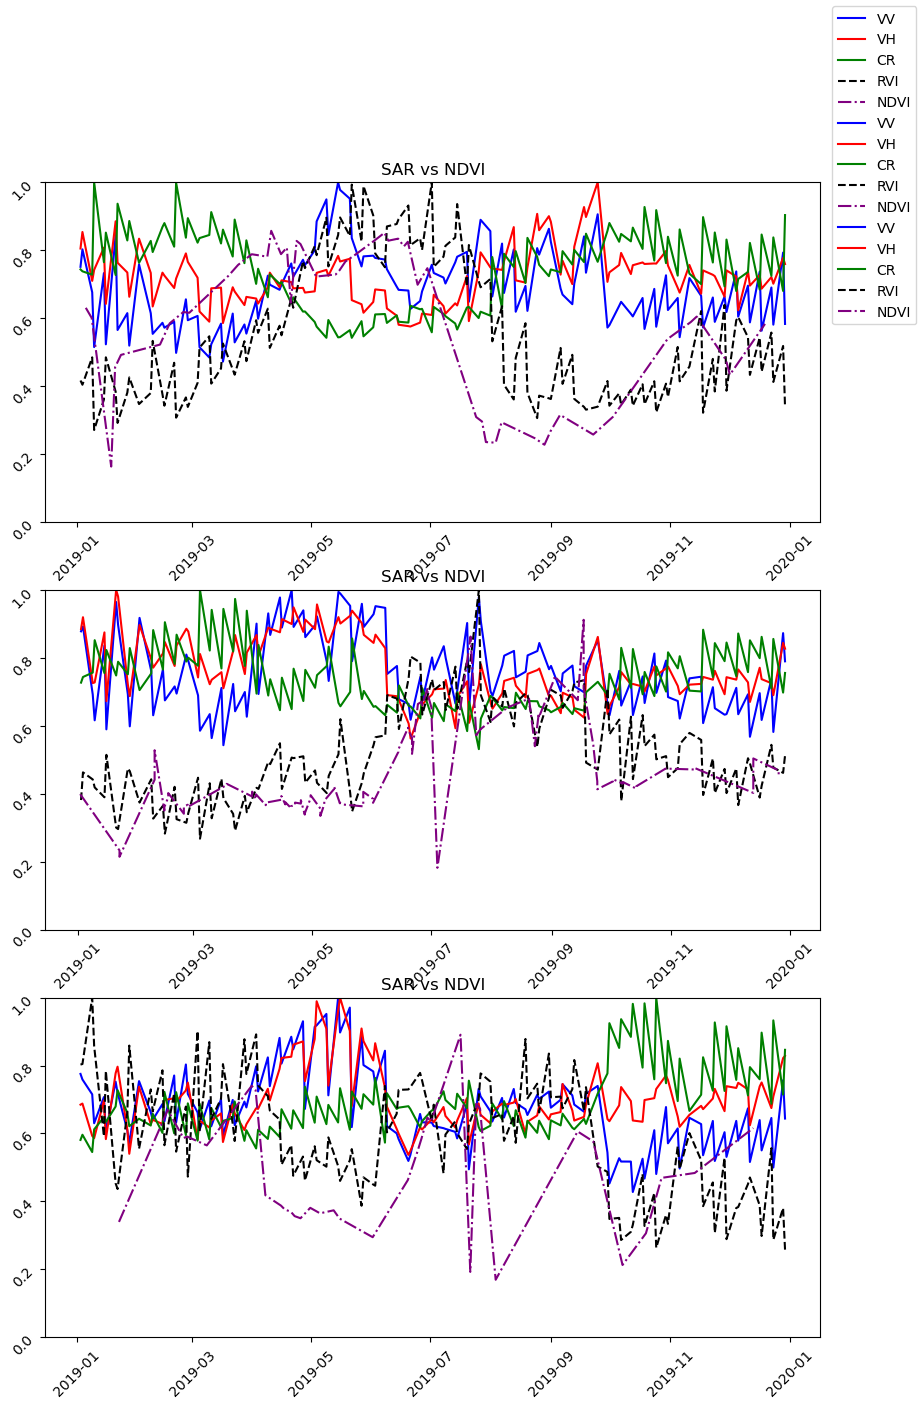

In [250]:
plot_SAR_bands(N = 30, coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[0, 6, 8]], reducer_code = 'mean')

In [59]:
def compare_veg_indices(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=1500, bands = ['EVI','NDVI', 'SAVI', 'NDWI', 'CIG']):
    fig, axs = plt.subplots(len(coords), 1, figsize = (10, 15))
    for coord_index, coord in enumerate(coords):
        IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale=mask_scale, buffer_size=buffer_size,
                                           spectral_indices = bands)
        masked = csPlus_mask_collection(IC)
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
        ts = getTimeSeriesByRegion(masked,
            reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
            geometry = random_points,
            bands = bands,#['B4','B8'],
            scale = mask_scale)
        x = geemap.ee_to_df(ts)
        for VI_index, veg_index in enumerate(bands):
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            colour = ['blue', 'red', 'green', 'black', 'purple'][VI_index]
            line_style = ['solid', 'solid', 'dotted', 'dashed', 'dashdot'][VI_index]
            axs[coord_index].plot(xreduced['date'], (xreduced[veg_index]/np.max([1, xreduced[veg_index].max()]))*np.sign( xreduced[veg_index].max()),
                                  c = colour, label = veg_index, linestyle = line_style)
        axs[coord_index].set_title('Comparing different VIs')
        axs[coord_index].tick_params(labelrotation=45)
        axs[coord_index].set_ylim([0, 1])
    fig.legend()
    fig.tight_layout()

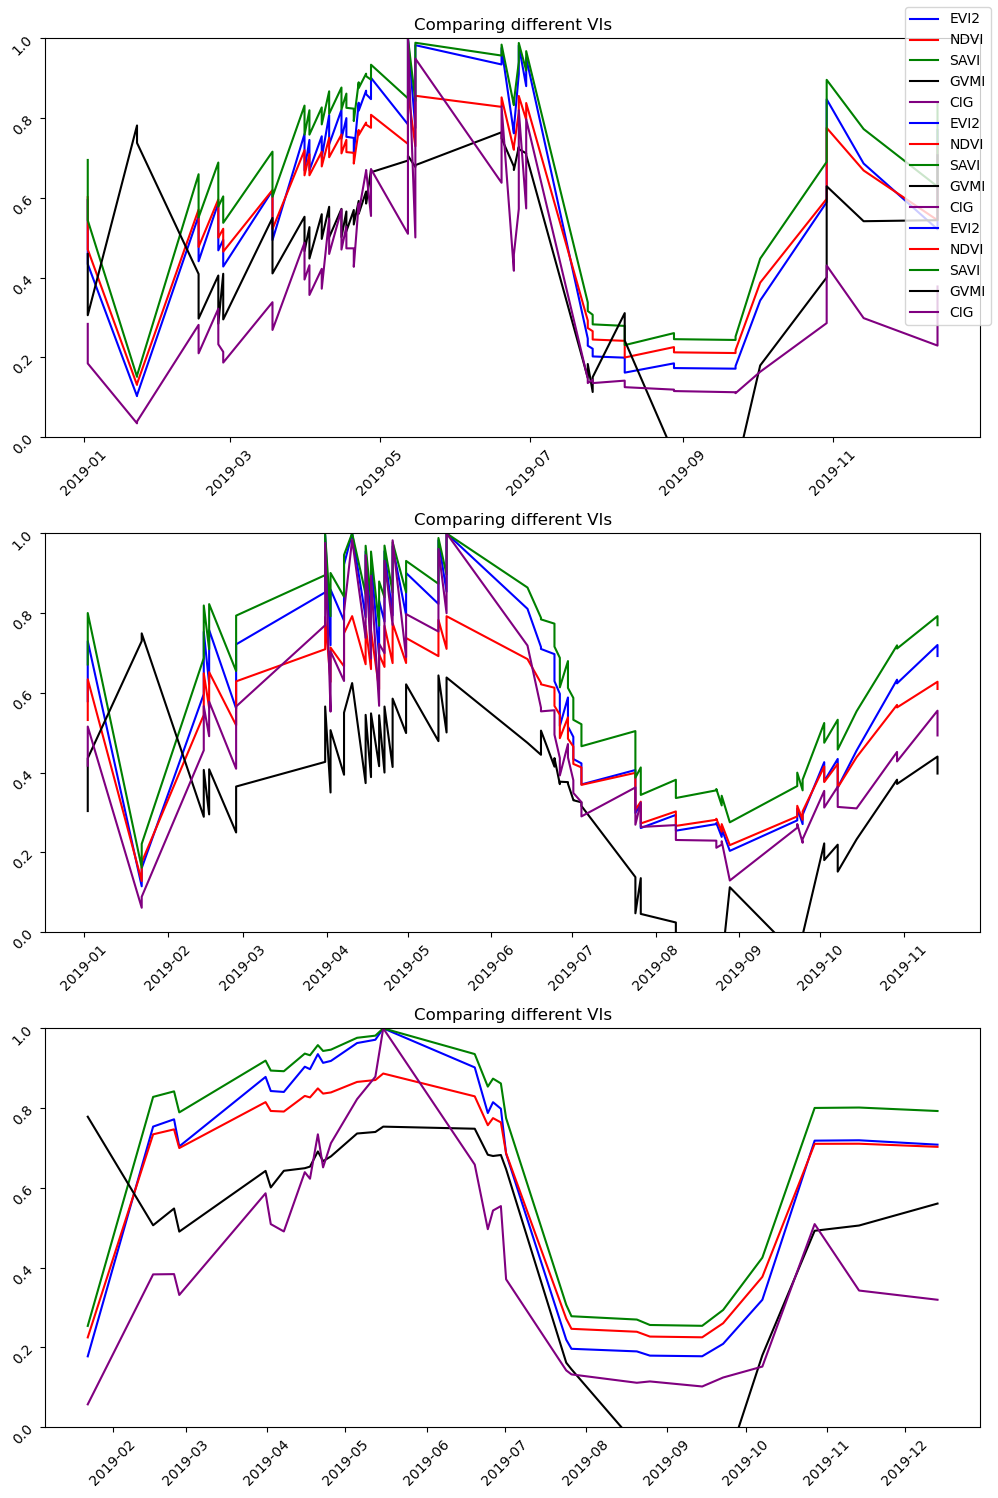

In [175]:
compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 8]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
                   bands = ['EVI2','NDVI', 'SAVI', 'GVMI', 'CIG'])

In [176]:
#compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 8]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
#                   bands = ['NDVI', 'BNDVI', 'EVI2','CVI', 'CIG'])

In [177]:
#compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 8]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
#                   bands = ['NDVI', 'GARI', 'GBNDVI','GLI', 'GNDVI'])

In [178]:
#compare_veg_indices(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[3, 6, 7, 8, 9]], mask_scale = 500, buffer_size=5000, crop_type = 'M',
#                   bands = ['NDVI', 'GVMI', 'RVI', 'SAVI', 'VARI'], year=2020)

In [6]:
def compare_crop_masks(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:2],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=1500):
    fig, axs = plt.subplots(1, 3, figsize = (20, 10))
    for mask_index in range(3):
        first_coord = True
        for coord in coords:
            print(coord)
            if mask_index == 0:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            elif mask_index == 1:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory, just_eujrc = True,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            elif mask_index == 2:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory, combine_eujrc = True,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            masked = csPlus_mask_collection(IC)
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            ts = getTimeSeriesByRegion(masked,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = ['EVI','NDVI'],#['B4','B8'],
                scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts)
            except:
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            name_choices = ['s2 cloud mask', 'google cloud mask']
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            colour = ['blue', 'red', 'green'][mask_index]
            if first_coord:
                mask_name = ['World cereal',
                             'EUJRC',
                             'World cereal and EUJRC'][mask_index]
                axs[mask_index].plot(xreduced['date'], xreduced['NDVI'], 
                                     alpha = 0.5, c = colour,
                                     label = f'Using {mask_name} crop masks, {reducer_code} reduced')
                first_coord = False
            else:
                axs[mask_index].plot(xreduced['date'], xreduced['NDVI'], 
                         alpha = 0.5, c=colour)
            axs[mask_index].set_title(mask_name)
            axs[mask_index].tick_params(labelrotation=45)
    fig.legend()
    fig.tight_layout()

[  54.3167   10.05   7504.    ]
[  54.4333    9.8167 7521.    ]
[  54.4       8.7667 7532.    ]
[  54.3167   10.05   7504.    ]
[  54.4333    9.8167 7521.    ]
[  54.4       8.7667 7532.    ]
[  54.3167   10.05   7504.    ]
[  54.4333    9.8167 7521.    ]
[  54.4       8.7667 7532.    ]


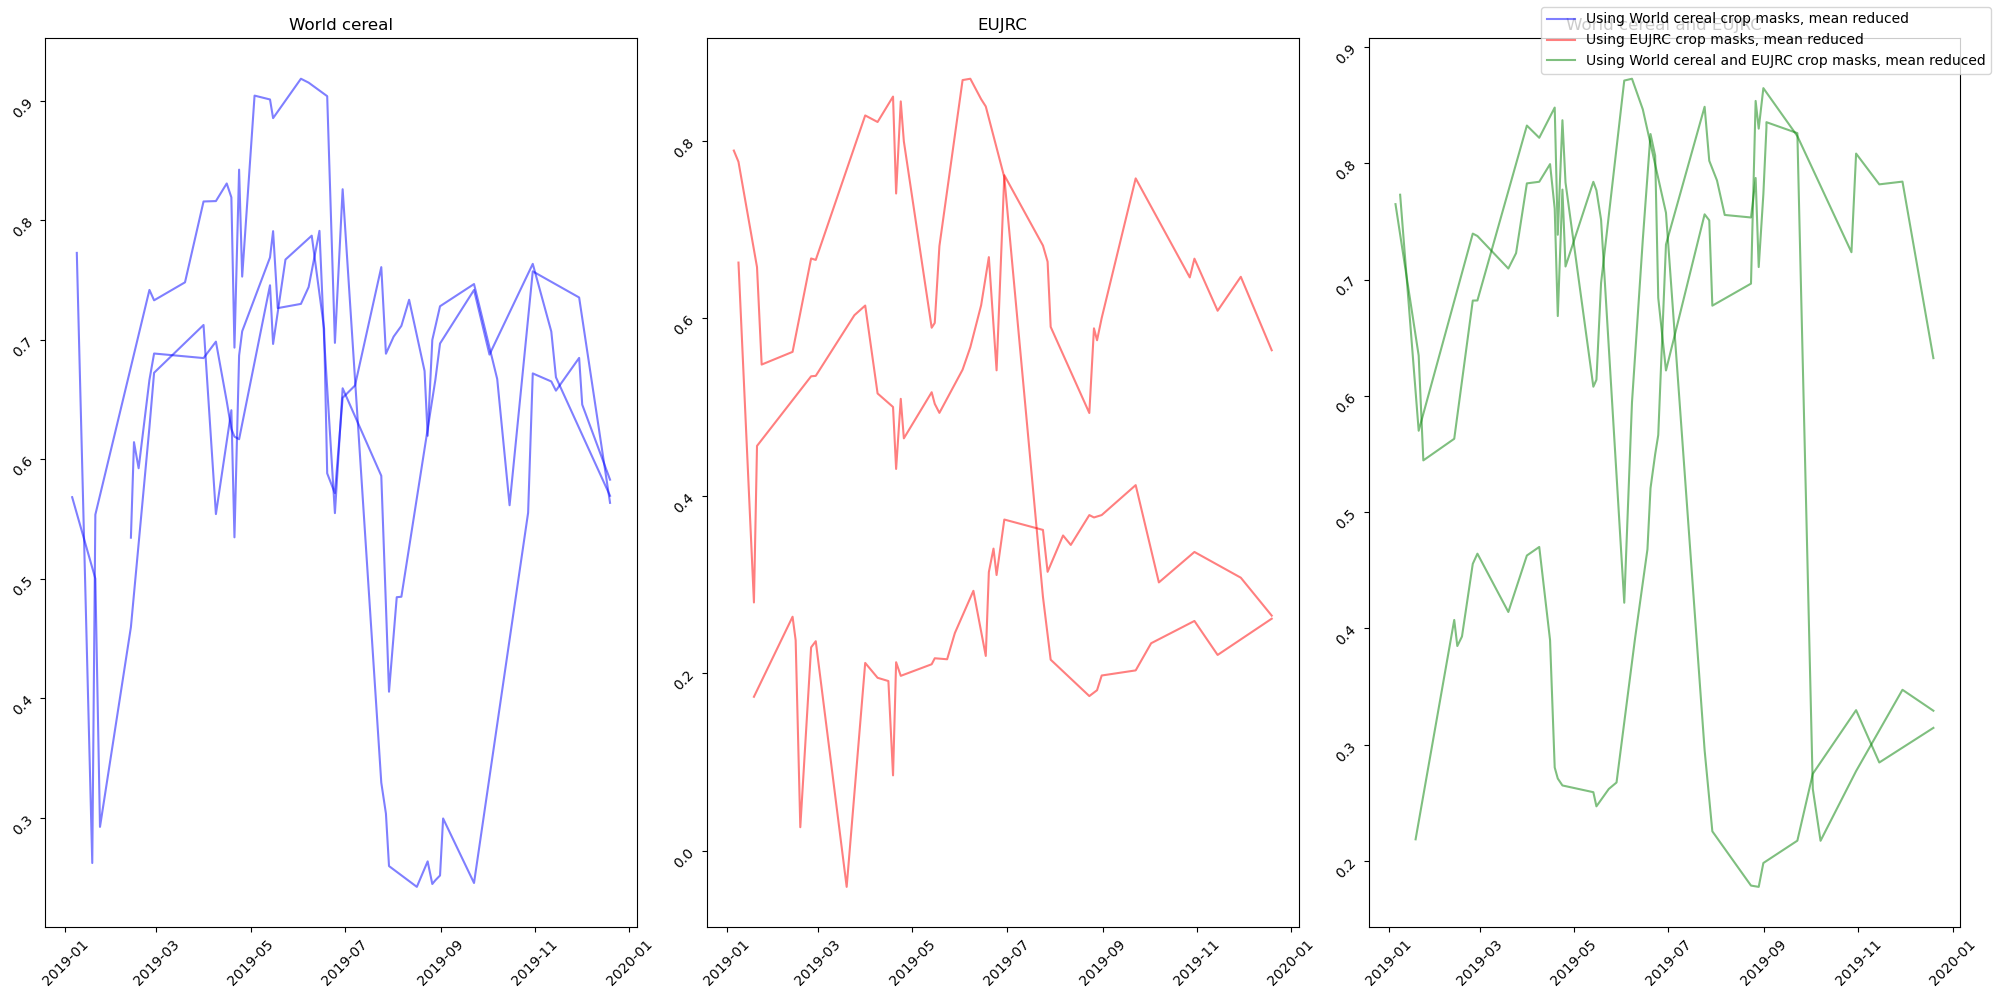

In [7]:
compare_crop_masks(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3], mask_scale = 500, buffer_size=5000, crop_type = 'ww')

In [16]:
def compare_cloud_masks(instrument = 'COPERNICUS/S2_SR_HARMONIZED', 
                                 coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                                 country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                                reducer_code = 'median', N=1):
    IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory)
    fig, ax = plt.subplots()
    for index, masker in enumerate([mask_s2_clouds_collection, csPlus_mask_collection]):
        masked = masker(IC)
        random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
        ts = getTimeSeriesByRegion(masked,
            reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
            geometry = random_points,
            bands = ['EVI','NDVI'],#['B4','B8'],
            scale = 10)
        x = geemap.ee_to_df(ts)
        x['date'] = pd.to_datetime(x['date'])
        x = x.where(x['NDVI']!=-9999).dropna()
        name_choices = ['s2 cloud mask', 'google cloud mask']
        xreduced = x.where(x['reducer'] == reducer_code).dropna()
        ax.plot(xreduced['date'], xreduced['NDVI'], label = f'{name_choices[index]}, {reducer_code} reduced')
    fig.legend()
                                 

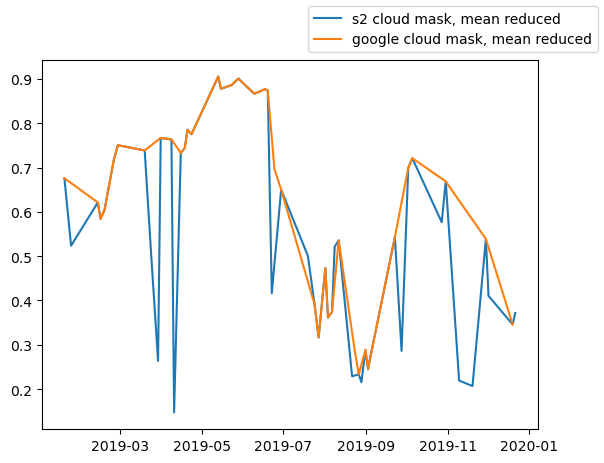

In [17]:
compare_cloud_masks(reducer_code = 'mean', coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[2])

In [66]:
def compare_reducers(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median'):
    fig, ax, IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory)
    masked = csPlus_mask_collection(IC)
    N=5
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
    
    ts = getTimeSeriesByRegion(masked,
        reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
        geometry = random_points,
        bands = ['EVI','NDVI'],#['B4','B8'],
        scale = 10)
    x = geemap.ee_to_df(ts)
    x['date'] = pd.to_datetime(x['date'])
    x = x.where(x['NDVI']!=-9999).dropna()
    xmean = x.where(x['reducer'] == 'mean').dropna()
    xmedian = x.where(x['reducer'] == 'median').dropna()
    xmax = x.where(x['reducer'] == 'max').dropna()
    name_choices = ['s2 cloud mask', 'google cloud mask']
    ax.plot(xmean['date'], xmean['NDVI'], label = f'google cloud mask, mean reduced')
    ax.plot(xmedian['date'], xmedian['NDVI'], label = f'google cloud mask, median reduced')
    ax.plot(xmax['date'], xmax['NDVI'], label = f'google cloud mask, max reduced')
    fig.legend()

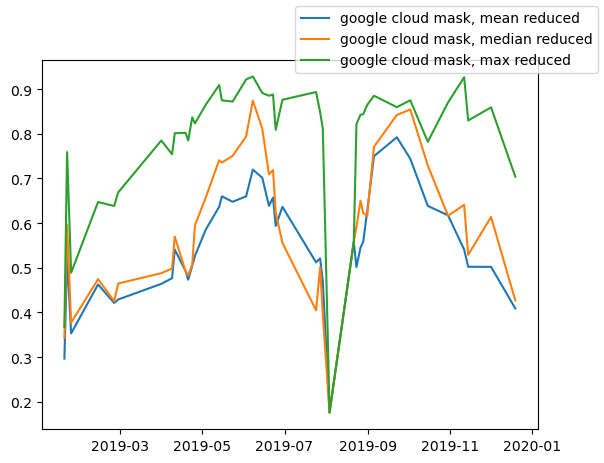

In [67]:
compare_reducers()

In [216]:
def compare_reducers_SAR(instrument = 'COPERNICUS/S1_GRD',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median', mask_scale = 250, buffer_size = 3000):
    N = 30
    fig, ax = plt.subplots(figsize = (10, 10))
    IC_SAR, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                            country = country, crop_type = crop_type, 
                                            year = year, root_directory = root_directory,
                                           mask_scale=mask_scale, buffer_size=buffer_size,
                                           indices = False)
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
    RVI = IC_SAR.map(rvi_from_s1_grd)
    #RVI_outlier_mask = RVI.lt(1.5)
    RVI = IC_less_than(RVI, 1.5)
    #RVI = RVI.updateMask(RVI_outlier_mask)
    ts = getTimeSeriesByRegion(RVI,
        reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
        geometry = random_points,
        bands = ['RVI'],#['B4','B8'],
        scale = mask_scale)
    x = geemap.ee_to_df(ts)
    x['date'] = pd.to_datetime(x['date'])
    x = x.sort_values(by='date')
    x = x.where(x['RVI']!=-9999).dropna()
    x = x.where(x['RVI'] < 2).dropna()
    xmean = x.where(x['reducer'] == 'mean').dropna()
    xmedian = x.where(x['reducer'] == 'median').dropna()
    xmax = x.where(x['reducer'] == 'max').dropna()
    name_choices = ['s2 cloud mask', 'google cloud mask']
    ax.plot(xmean['date'], xmean['RVI'], label = f'google cloud mask, mean reduced')
    ax.plot(xmedian['date'], xmedian['RVI'], label = f'google cloud mask, median reduced')
    ax.plot(xmax['date'], xmax['RVI'], label = f'google cloud mask, max reduced')
    fig.legend()

In [204]:
def img_less_than(img, upper_bound):
    new_mask = img.lt(upper_bound)
    return img.updateMask(new_mask)

In [205]:
def IC_less_than(IC, upper_bound):
    return IC.map(lambda img: img_less_than(img, upper_bound))

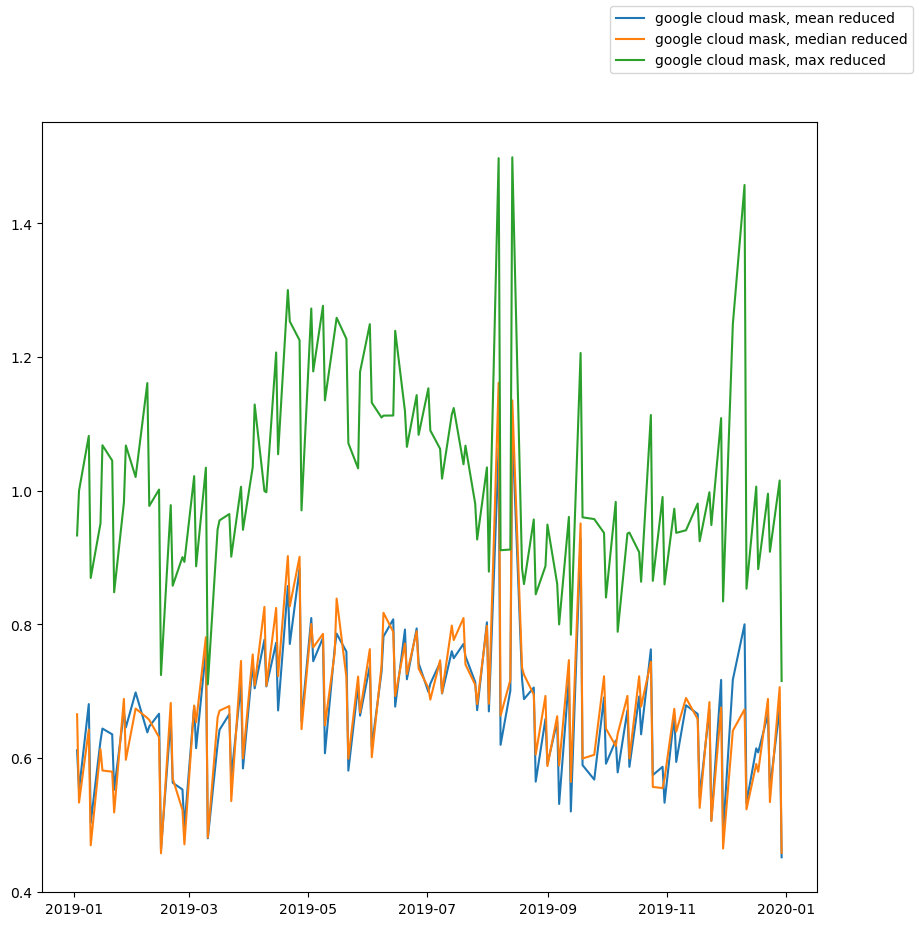

In [217]:
compare_reducers_SAR()

In [159]:
def compare_sample_sizes(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:5],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median'):
    fig, ax = plt.subplots(len(coords), 1, figsize = (10, 5))
    for coord_index, coord in enumerate(coords):
        print(f'Coordinate {coord_index + 1}')
        IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory)
        for N in range(1, 50, 10):
            masked = csPlus_mask_collection(IC)
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})#
            ts = getTimeSeriesByRegion(masked,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = ['EVI','NDVI'],#['B4','B8'],
                scale = 10)
            x = geemap.ee_to_df(ts)
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            ax[coord_index].plot(xreduced['date'], xreduced['NDVI'], label = f'Google cloud mask, {reducer_code} reduced')
        if coord_index == 0:
            fig.legend()

In [184]:
def compare_sample_sizes_SAR(instrument = 'COPERNICUS/S1_GRD',
                     coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'mean', mask_scale = 100, buffer_size = 1500):
    fig, axs = plt.subplots(len(coords), 1, figsize = (10, 10))
    for coord_index, coord in enumerate(coords):
        print(f'Coordinate {coord_index + 1}')
        IC_SAR, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                country = country, crop_type = crop_type, 
                                                year = year, root_directory = root_directory,
                                               mask_scale=mask_scale, buffer_size=buffer_size,
                                               indices = False)
        for N in range(1, 100, 30):
            #random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})#
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            RVI = IC_SAR.map(rvi_from_s1_grd)
            ts = getTimeSeriesByRegion(RVI,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = ['RVI'],#['B4','B8'],
                scale = mask_scale)
            x = geemap.ee_to_df(ts).sort_index(ascending=True)
            x['date'] = pd.to_datetime(x['date'])
            x = x.sort_values(by='date')
            x = x.where(x['RVI']!=-9999).dropna()
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            xreduced = xreduced.where(xreduced['RVI'] < 1).dropna()
            axs[coord_index].plot(xreduced['date'], (xreduced['RVI']),#/np.max([1, np.abs(xreduced['RVI']).max()]))*np.sign(xreduced['RVI'].max()),
                                  label = f'RVI, {N} samples')
            if coord_index == 0:
                fig.legend()

Coordinate 1
Coordinate 2
Coordinate 3


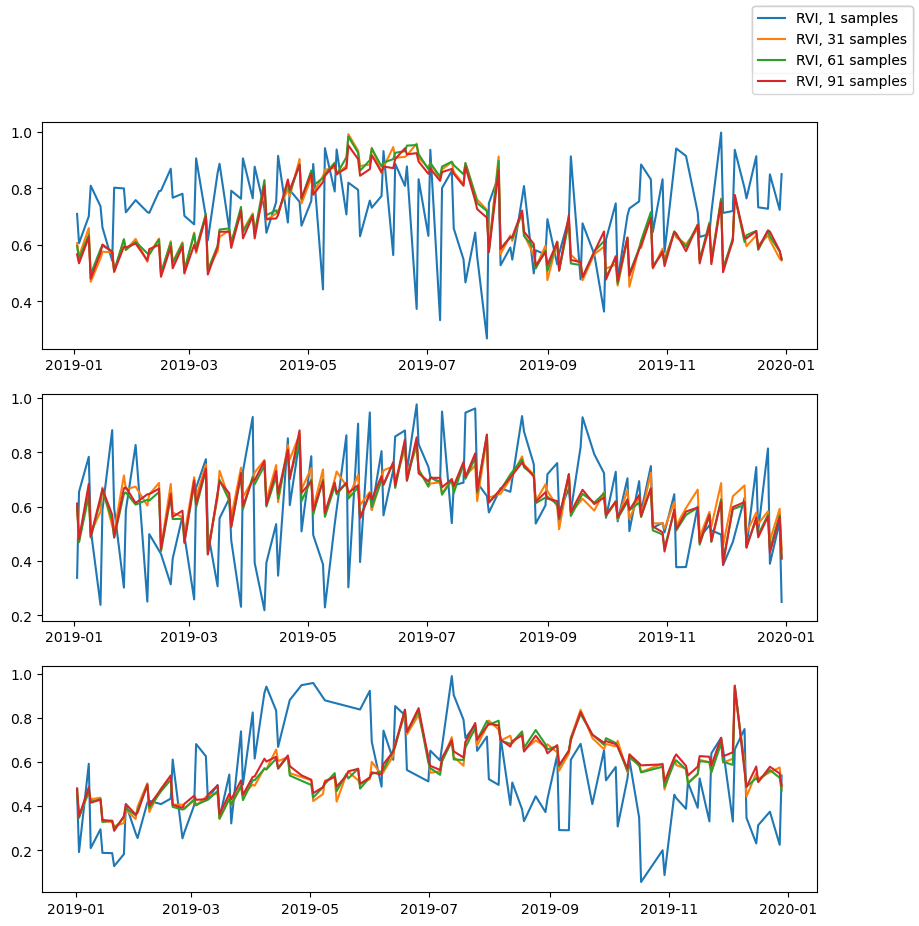

In [185]:
compare_sample_sizes_SAR()

Coordinate 0
Coordinate 1
Coordinate 2


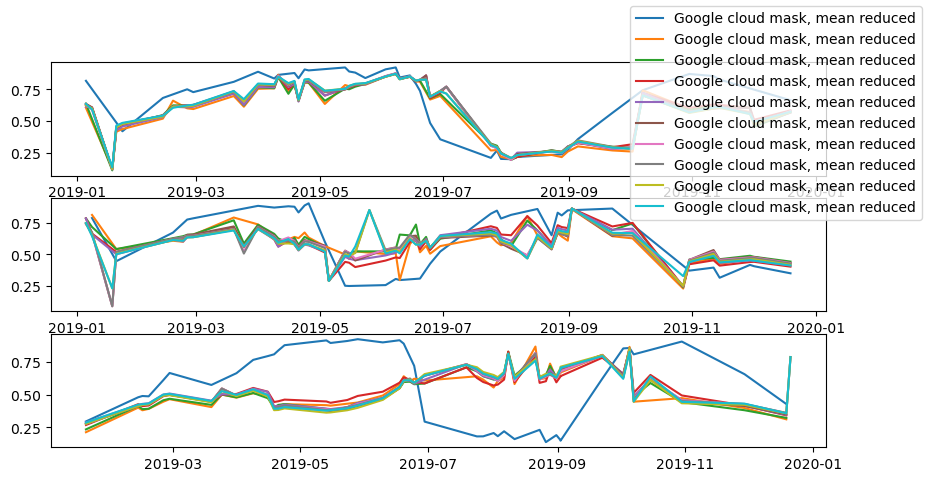

In [158]:
compare_sample_sizes(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3])

In [15]:
def get_image_index(image_collection, index):
    imgList = image_collection.toList(999)
    return ee.Image(ee.List(imgList).get(index))

In [18]:
def box_around_point(coord, box_width):
    '''
    coord: coordinate in (lat, lon) (?)
    '''
    return ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)

In [26]:
def compare_images(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median'):
    fig, ax, IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory)
    masked = csPlus_mask_collection(IC)
    IC = IC.filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',50)
    location = box_around_point(coord, 0.01)
    fig, axs = plt.subplots(4, 5, figsize = (24, 60))
    for index in range(20):
        img2ndImage=get_image_index(masked, index)
        img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs[index // 5, index % 5], region=location,cmap="viridis",
                              color="k")
    fig.savefig('manyplots.jpg')
    

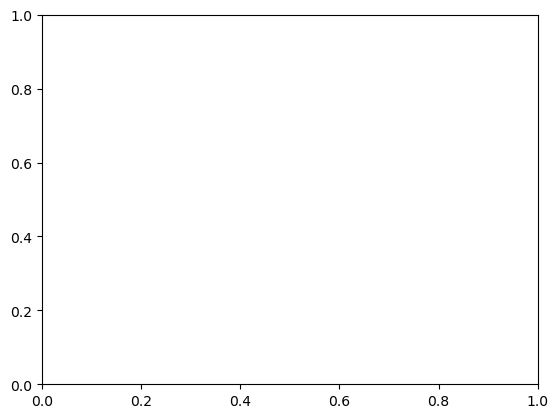

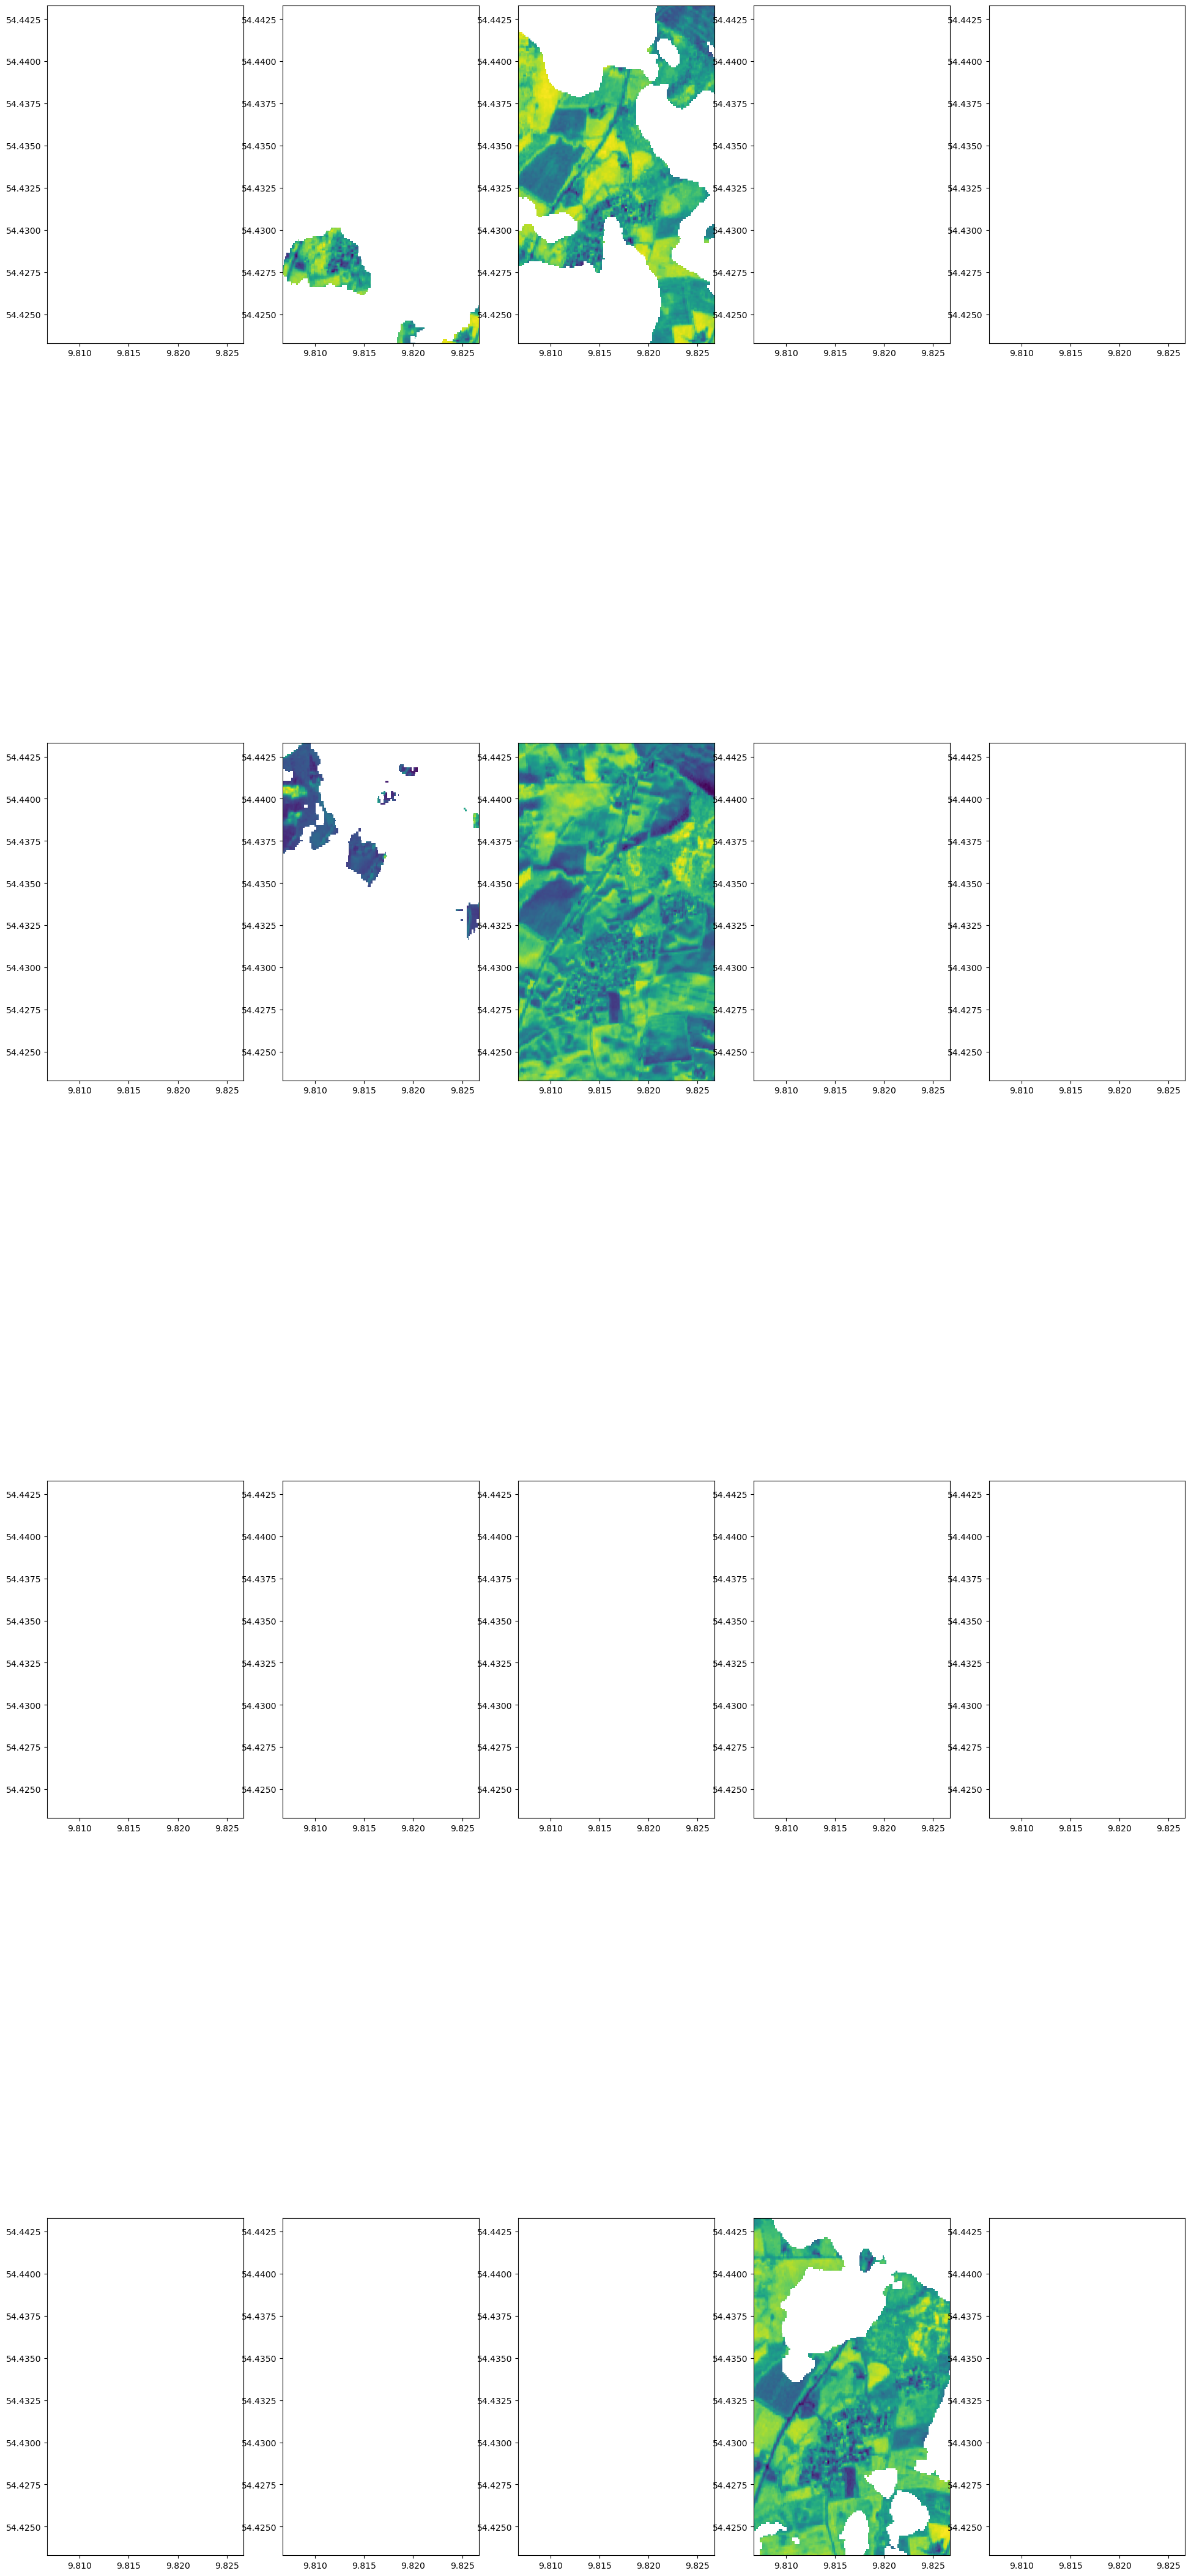

In [27]:
compare_images()

In [161]:
def compare_crop_mask_images(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                            buffer_size = 1500, mask_scale = 10):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    fig, axs = plt.subplots(1, 3, figsize = (20, 10))
    first_coord = True
    for coord_index in range(3):
        print(coord_index)
        coord = coords[coord_index]
        location = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size)
        grid_cell = location.bounds()
        
        eujrc = ee.ImageCollection('JRC/D5/EUCROPMAP/V1').filterDate('2018-01-01', '2023-01-01').mosaic()
        eujrc_maize = eujrc.select('classification').eq(216)
        eujrc_maize = eujrc_maize.updateMask(eujrc_maize)
        region = eujrc_maize.clip(grid_cell).geometry()
        eujrc_vectors = eujrc_maize.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        eujrc_vectors = eujrc_vectors.map(lambda feat: feat.set('mask_used', 0))
        
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', 'tc-maize-main')).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gte(0)
        region = crop.clip(grid_cell).geometry()
        WC_vectors = crop.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors = WC_vectors.map(lambda feat: feat.set('mask_used', 1))

        #Take out update mask if you want just worldcereals
        WC_and_eujrc = world_cereals.filter(product_codes[crop_type]).mosaic().updateMask(eujrc_maize).select('classification').gte(0)
        WC_eujrc_vectors = WC_and_eujrc.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_eujrc_vectors = WC_eujrc_vectors.map(lambda feat: feat.set('mask_used', 2))

        all_together = eujrc_vectors.merge(WC_vectors).merge(WC_eujrc_vectors)
        all_together.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        
        #WC_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        #eujrc_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        #WC_eujrc_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        
        #crop.geetools.plot(bands = ['classification'], ax = axs[coord_index + 2], region=location, scale = mask_scale/10000)
        #eujrc_maize.geetools.plot(bands = ['classification'], ax = axs[coord_index + 1], region=location, scale = mask_scale/10000)
        #WC_and_eujrc.geetools.plot(bands = ['classification'], ax = axs[coord_index], region=location,cmap="Purples")
        fig.colorbar(axs[coord_index].collections[0], label="mask code")
    fig.tight_layout()

In [ ]:
coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0]


0
1
2


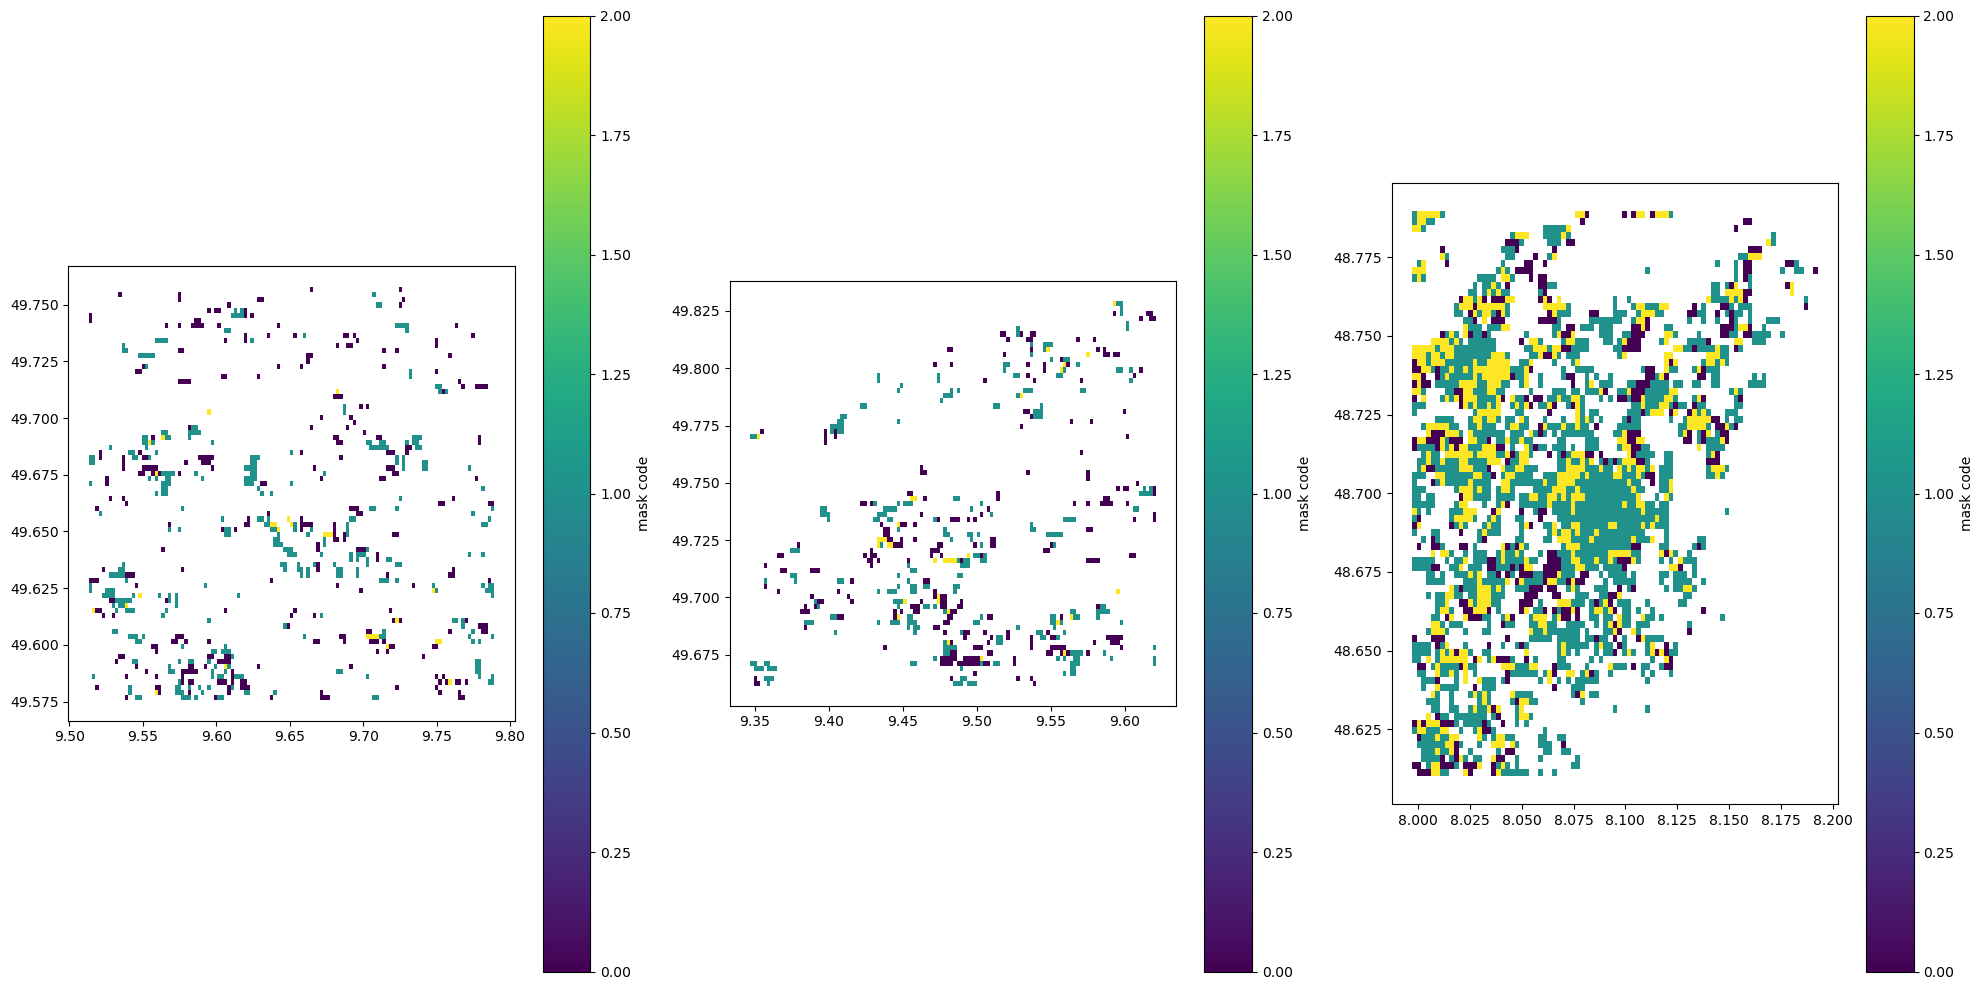

In [163]:
compare_crop_mask_images(coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[500:503],
                         buffer_size = 10000, mask_scale = 250)

In [72]:
def worldcereal_to_check(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median', mask_scale = 250, buffer_size = 5000):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory, mask_scale = 1000)
    fig, ax = plt.subplots()
    world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100')
    crop = world_cereals.filter(product_codes[crop_type]).map(lambda image: image.updateMask(image.neq(0))).mosaic().select('classification').gte(0)
    N = 100
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})
    box_width = 0.02
    location = ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)
    feats = ee.FeatureCollection([ee.Feature(random_points.geometry().buffer(10))])
    grid_cell_lon = coord[1]
    grid_cell_lat = coord[0]
    grid_cell = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(buffer_size).bounds()
    region = crop.clip(grid_cell).geometry()
    vectors = crop.reduceToVectors(**{
        'geometry': location, #region,
        'scale': mask_scale,
        'maxPixels': 1e13,
        'bestEffort':True,
        'eightConnected': False,
        'geometryInNativeProjection': False,
        'geometryType':'bb'
        })#.map(lambda x: x.buffer(-20))
    crop.geetools.plot(bands = ['classification'], fc=vectors, ax = ax, region=location,cmap="viridis", #fc=points, 
                              color="red", scale = mask_scale/100000)
    

/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


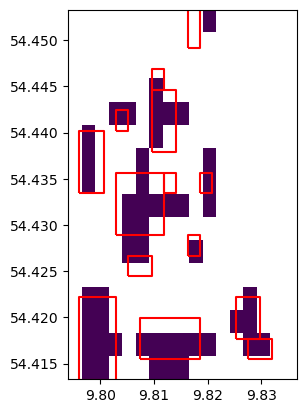

In [73]:
worldcereal_to_check(mask_scale = 250)

In [ ]:
    fig, axs = plt.subplots(figsize = (10, 10))
    box_width=0.02
    location = ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)
    masked = csPlus_mask_collection(IC)
    img2ndImage=get_image_index(masked, 7)
    img2ndImage.geetools.plot(bands = ['NDVI'], ax = axs, region=location,cmap="viridis", #fc=points, 
                              color="red")
    cbar = fig.colorbar(axs.images[0], label="NDVI")
    fig, axs = plt.subplots(figsize = (10, 10))
    crop.geetools.plot(bands = ['classification'], fc=vectors, ax = axs, region=location,cmap="viridis", #fc=points, 
                              color="red")
    

In [6]:
def addNDVI(image, bands = ['sur_refl_b01', 'sur_refl_b02']):
    ndvi = image.normalizedDifference(bands).rename('ndvi')
    return image.addBands([ndvi])

In [98]:
class timeseries_downloader:
    def __init__(self, coords):
        self.coords = coords
        
    def initiate_image_collection(self, instrument = "COPERNICUS/S2_SR_HARMONIZED", bands = ['B4', 'B8'], 
                                  start_date = '2000-01-01', end_date = '2022-12-31', 
                                  QC_function = mask_s2_clouds_collection, pixel_scale = 500):
        self.bands = bands
        self.dataset = ee.ImageCollection(instrument).filterDate(start_date, end_date)
        self.dataset = QC_function(self.dataset)
        self.dataset = self.dataset.select(*bands)
        self.pixel_scale = pixel_scale
        
    def read_at_coords(self, box_width = 0.002):
        for coord_index, coord in enumerate(self.coords):
            print(coord_index)
            location = box_around_point(coord, box_width)
            filtered_dataset = self.dataset.filterBounds(location)
            filtered_dataset = reduce_region_collection(filtered_dataset, location, reducer_code = 'median', pixel_scale = self.pixel_scale)
            print('filtered!')
            df = collection_properties_to_frame(filtered_dataset, coord, self.bands, reducer_code = 'median')
            if coord_index == 0:
                self.df_full = df
            else:
                self.df_full = pd.concat([self.df_full, df])

def box_around_point(coord, box_width):
    '''
    coord: coordinate in (lat, lon) (?)
    '''
    return ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)

def get_mean(image, location, pixel_scale= 500):
    return image.set('mean', image.reduceRegion(ee.Reducer.mean(), location , pixel_scale))

def get_median(image, location, pixel_scale= 500):
    return image.set('median', image.reduceRegion(ee.Reducer.median(), location , pixel_scale))

def reduce_region_collection(image_collection, location, reducer_code = 'median', pixel_scale = 500):
    if reducer_code == 'mean':
        return image_collection.map(lambda img: get_mean(img, location, pixel_scale = pixel_scale))
    elif reducer_code == 'median':
        return image_collection.map(lambda img: get_median(img, location, pixel_scale = pixel_scale))
    else:
        print('invalid reducer code')

def collection_properties_to_frame(image_collection, coord, bands, reducer_code = 'median'):
    print('collecting...')
    timelist = image_collection.aggregate_array('system:time_start').getInfo()
    print('Times retrieved!')
    bandlist = image_collection.aggregate_array(reducer_code).getInfo()
    print('Data retrieved!')
    data = {'Time': timelist,
            'lat': [coord[0] for count in range(len(timelist))],
            'lon': [coord[1] for count in range(len(timelist))],
            'Stations_Id': [np.int64(coord[2]) for count in range(len(timelist))]
           }
    for band in bands:
        data[f'{reducer_code} {band}'] = [band_data[band] for band_data in bandlist]
    df = pd.DataFrame(data)
    df['formatted_time'] = pd.to_datetime(df['Time'], unit='ms').dt.strftime('%Y-%m-%d-%H-%M-%S')
    return df